In [1]:
#imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import json
import time
import networkx as nx

In [2]:
class ReleaseNode:
    """
    Represents a node in a networkx diagram with basic attributes and functionalities(TBD).

    Attributes:
        release_name (str): Name of the music release.
        release_mbid (str): MusicBrainz ID.
        release_credits (list): List of credits on the music release.
        release_credit_mbid (str): MusicBrainz ID.
    """
    def __init__(self, release_title, release_mbid, release_credit, release_credit_mbid):
        """
        Initializes the Release_Node object.

        Args:
            release_name (str): Name of the music release.
            release_mbid (str): MusicBrainz ID.
            release_credits (list): List of credits on the music release.
            release_credit_mbid (str): MusicBrainz ID.
        """
        self.release_title = release_title
        self.release_mbid = release_mbid
        self.release_credit = release_credit
        self.release_credit_mbid = release_credit_mbid

    def __repr__(self):
        f"('{self.release_title}', {self.release_mbid}, '{self.release_credit}', {self.release_credit_mbid})"

    def __str__(self):
        return f"{self.release_title}\n{self.release_credit}"

In [3]:
def search_recording(artist_name, release_title):
    """
    Retrieves all release groups for a given artist using their MusicBrainz ID.

    Args:
        artist_name (str): Name of the artist.
        release_title (str): Name of the Release

    Returns:
        list: The MBID for the release. This is the basis node for the network.
    """
    base_url = "https://musicbrainz.org/ws/2/release/"
    params = {
        "query": f"artist:\"{artist_name}\" AND release:\"{release_title}\"",
        "fmt": "json"
    }
    headers = {"User-Agent": "MusicProject/1.0 (bittah.pupil@proton.me)"} # Replace with your app info

    response = requests.get(base_url, params=params, headers=headers)
    response.raise_for_status() # Raise an exception for bad status codes
    data = response.json()
    
    if data and data.get('releases'):
        # Return the MBID of the first matching recording
        return data['releases'][0]['id'], data['releases'][0]['artist-credit'][0]['artist']['id']
    return None

# Example usage:
#artist = "Chico Hamilton"
#album = "Peregrinations"
#release_mbid = search_recording(artist, album)
#print(f"Recording MBID for '{album}' by '{artist}': {release_mbid}")

In [4]:
async def get_credits_for_recording(release_mbid):
    """
    Retrieves all the credits for a given release using the releases MusicBrainz ID.

    Args:
        release_mbid (str): MusicBrainz ID for the release.

    Returns:
        list: A list of all credited personnel (including artist) on the release based on the provided release mbid.
        This list includes the name of the credit, the role of the credit, and the mbid for the credit.
    """
    base_url = f"https://musicbrainz.org/ws/2/release/{release_mbid}"
    params = {
        "inc": "artist-credits+labels+recordings+recording-level-rels+work-rels+work-level-rels+artist-rels + release-groups",  # Include artist relationships
        "fmt": "json"
    }
    headers = {"User-Agent": "MusicProject/1.0 (bittah.pupil@proton.me)"}

    response = requests.get(base_url, params=params, headers=headers)
    response.raise_for_status()
    data = response.json()

    credits = []
    
    if data and data.get('artist-credit'):
       for track in data['media'][0]['tracks']:
            for credit in track['recording']['relations']:
                if credit['attributes'] == []:
                    attributes = 'Not Found'
                else:
                    attributes = credit['attributes']
                credits.append((track['number'], track['title'], credit.get('artist', {}).get('name', 'Not Found'), attributes, credit.get('artist', {}).get('id', 'Not Found')))
            for credit in track['artist-credit']:
                credits.append((track['number'], track['title'], credit.get('name', 'Not Found'), credit.get('attributes', 'Not Found'), credit.get('artist', {}).get('id', 'Not Found')))
    if data['relations']:
       for credit in data['relations']:
           trackNum = 'Not Found'
           trackTitle = 'Not Found'
           if credit['attributes'] == [] or not credit['attributes']:
               attributes = 'Not Found'
           else:
               attributes = credit['attributes']
           credits.append((trackNum, trackTitle, credit.get('artist', {}).get('name', 'Not Found'), attributes, credit.get('artist', {}).get('id', 'Not Found')))

    creditNames = []
    creditList = []
    for credit in credits:
        if credit[2] not in creditNames:
            creditNames.append(credit[2])
            creditList.append((credit[2],credit[3], credit[4]))
    
    return creditList

In [5]:
async def get_artist_releases(artist_mbid):
    """
    Retrieves all release groups for a given artist using their MusicBrainz ID.

    Args:
        artist_mbid (str): The MusicBrainz ID of the artist.

    Returns:
        list: A list of dictionaries, each representing a release group.
              Returns an empty list if no releases are found or an error occurs.
    """
    base_url = "https://musicbrainz.org/ws/2/release-group/"
    studio_albums = []
    limit = 100  # Maximum results per request
    offset = 0

    while True:
        params = {
            "artist": artist_mbid,
            "type": "album",
            "fmt": "json",
            "limit": limit,
            "offset": offset
        }
        headers = {
            "User-Agent": "MusicProject/1.0 (bittah.pupil@proton.me)" # Replace with your app name and contact email
        }

        try:
            response = requests.get(base_url, params=params, headers=headers)
            response.raise_for_status()  # Raise an exception for HTTP errors
            data = response.json()

            release_groups = data.get("release-groups", [])
            for rg in release_groups:
                # Filter out live albums and compilations
                secondary_types = rg.get("secondary-types", [])
            
                if "Live" not in secondary_types and "Compilation" not in secondary_types:
                    album_info = {
                        "title": rg.get("title"),
                        "mbid": rg.get("id"),
                        "first_release_date": rg.get("first-release-date", "Unknown"),
                        "primary_type": rg.get("primary-type"),
                        "secondary_types": secondary_types
                    }
                    studio_albums.append(album_info)

            # Check if there are more results to fetch
            if len(release_groups) < limit:
                break
            offset += limit
            time.sleep(1)

        except requests.exceptions.RequestException as e:
            print(f"Error fetching data: {e}")
            break
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON response: {e}")
            break

    return studio_albums

In [6]:
# provide initial inputs and retrieve release_mbid for the release
artist = "Earl Klugh"
album = "One on One"
release_data = search_recording(artist, album)
release_mbid = release_data[0]
release_credit_mbid = release_data[1]
print(f"Recording MBID for '{album}': {release_mbid}")
print(f"Credit MBID for '{artist}': {release_credit_mbid}")
print('\n')

basis_node = ReleaseNode(album, release_mbid, artist, release_credit_mbid)

G = nx.Graph()
G.add_node(basis_node)

if release_mbid:
    albumCredits = await get_credits_for_recording(release_mbid)
    print(albumCredits)
    print("\n\n")
else:
    print(f"Recording for '{album}' by '{artist}' not found.")

testList = []

#extract the one credts releases (for testing purposes will grab the first)
credit = albumCredits[3]
releasesFirstArtist = await get_artist_releases(credit[2])
print(f"Credit Name: {credit[0]}:")
for release in releasesFirstArtist:
    releaseNodeObject = ReleaseNode(release.get("title"), release.get("mbid"), credit[0], credit[2])
    G.add_node(releaseNodeObject)
    G.add_edge(releaseNodeObject, basis_node)

# extract each credits releases
#for credit in albumCredits:
#    releases = await get_artist_releases(credit[2])
#    print(f"Credit Name: {credit[0]}:")
#    for release in releases:
#        releaseNodeObject = ReleaseNode(release.get("title"), release.get("mbid"), credit[0], credit[2])
#        G.add_node(releaseNodeObject)
#        G.add_edge(releaseNodeObject, basis_node)

Recording MBID for 'One on One': 1609def0-5de3-4b10-be96-24ad6bb2a6f8
Credit MBID for 'Earl Klugh': f4d2fc5a-cacb-47c8-b096-ee73864b1aa8


[('Bob James', ['keyboard'], 'f4d2fc5a-cacb-47c8-b096-ee73864b1aa8'), ('Neil Jason', ['bass'], '18826a91-40a1-46c2-b0d6-dc3b95ca88ee'), ('Earl Klugh', ['guitar'], '5c44b1b8-07ad-4aca-ac5d-ebdad8e62e12'), ('Hubert Laws', ['flute'], '82208529-b45a-4b3e-92dd-02f6b14c6f18'), ('Ralph MacDonald', ['percussion'], 'b6be6ceb-f776-460f-a145-212fa306baa1'), ('Harvey Mason', ['drums (drum set)'], '1081d9bb-17fa-43cf-8b2e-05f7e6029f70'), ('David Nadien', ['violin'], '512598a0-8a21-4f93-93ca-f2ec75f98a4a'), ('Not Found', 'Not Found', 'Not Found'), ('Eric Gale', ['guitar'], '72323249-ff36-49d2-8925-f6b5a2946e5c'), ('Gary King', ['bass'], 'eba85512-eaf1-41d0-b007-679ae56bec42'), ('Ron Carter', ['bass'], '57db3f59-9c58-4f68-a00e-e044666c4828')]



Credit Name: Hubert Laws:


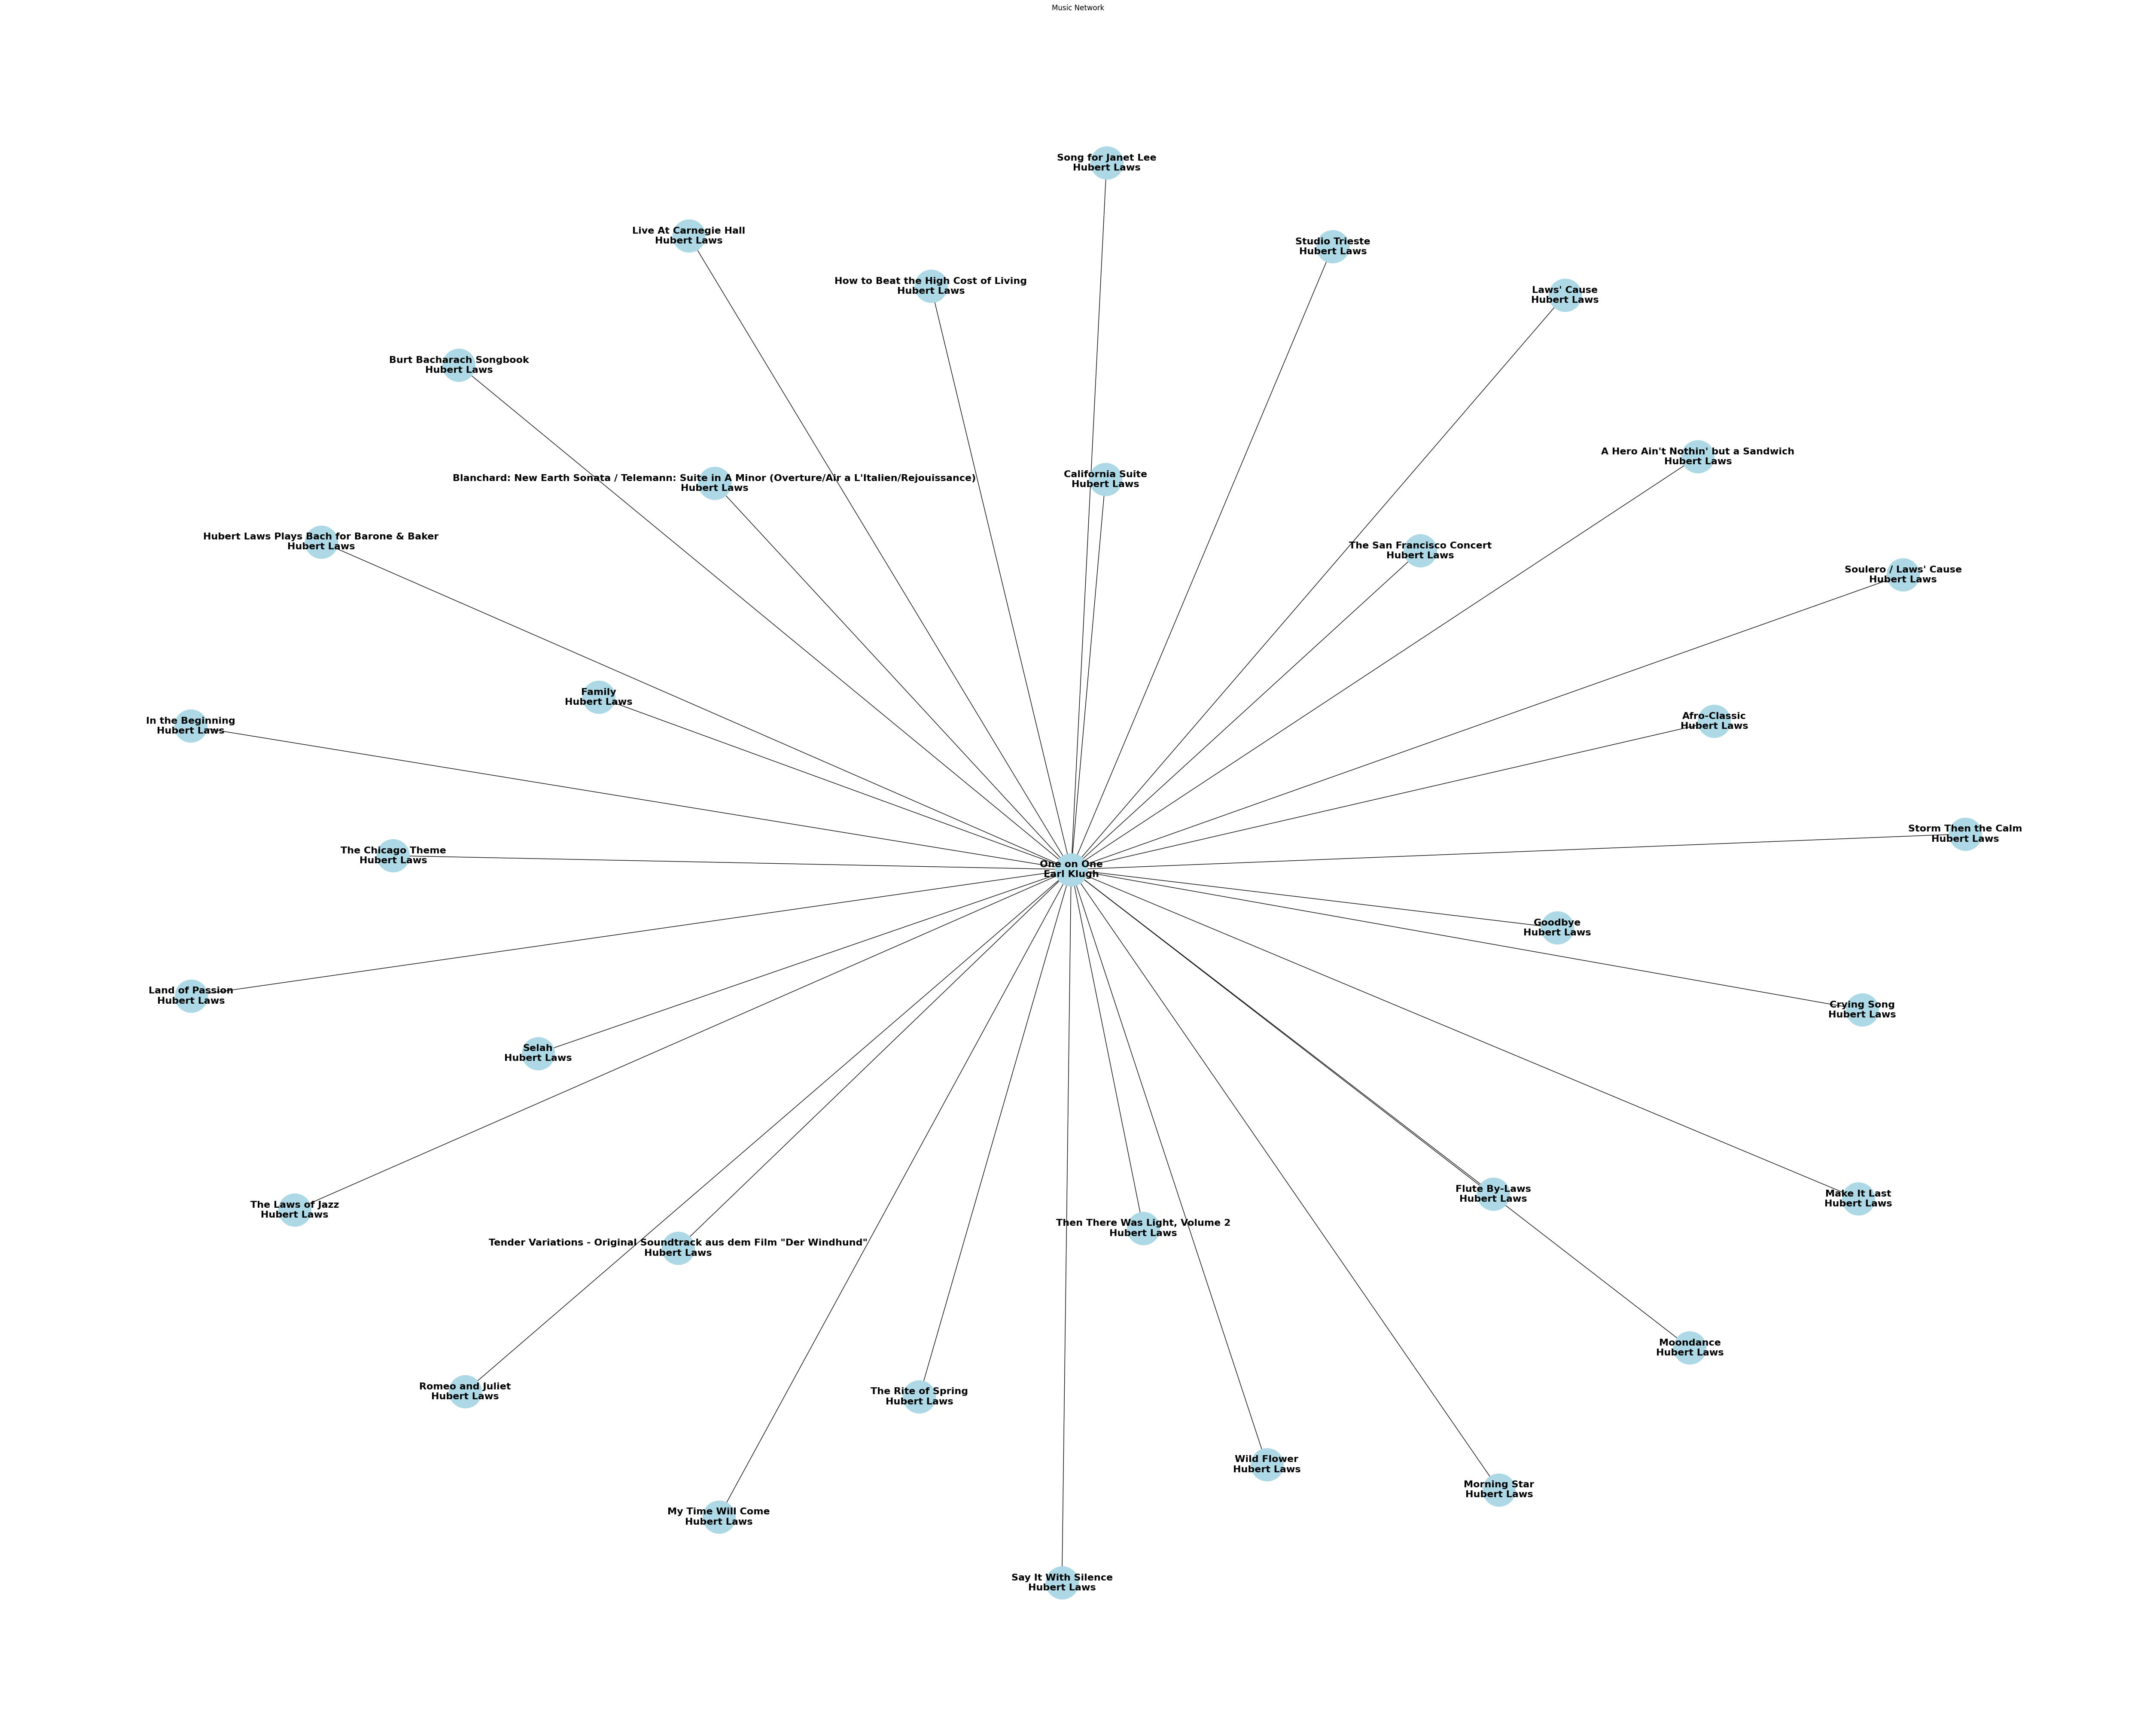

In [7]:
# display node diagram
plt.figure(figsize=(50, 40))
nx.draw(G, with_labels=True, node_color='lightblue', 
        node_size=3000, font_size=16, font_weight='bold')
plt.title("Music Network")
plt.show()

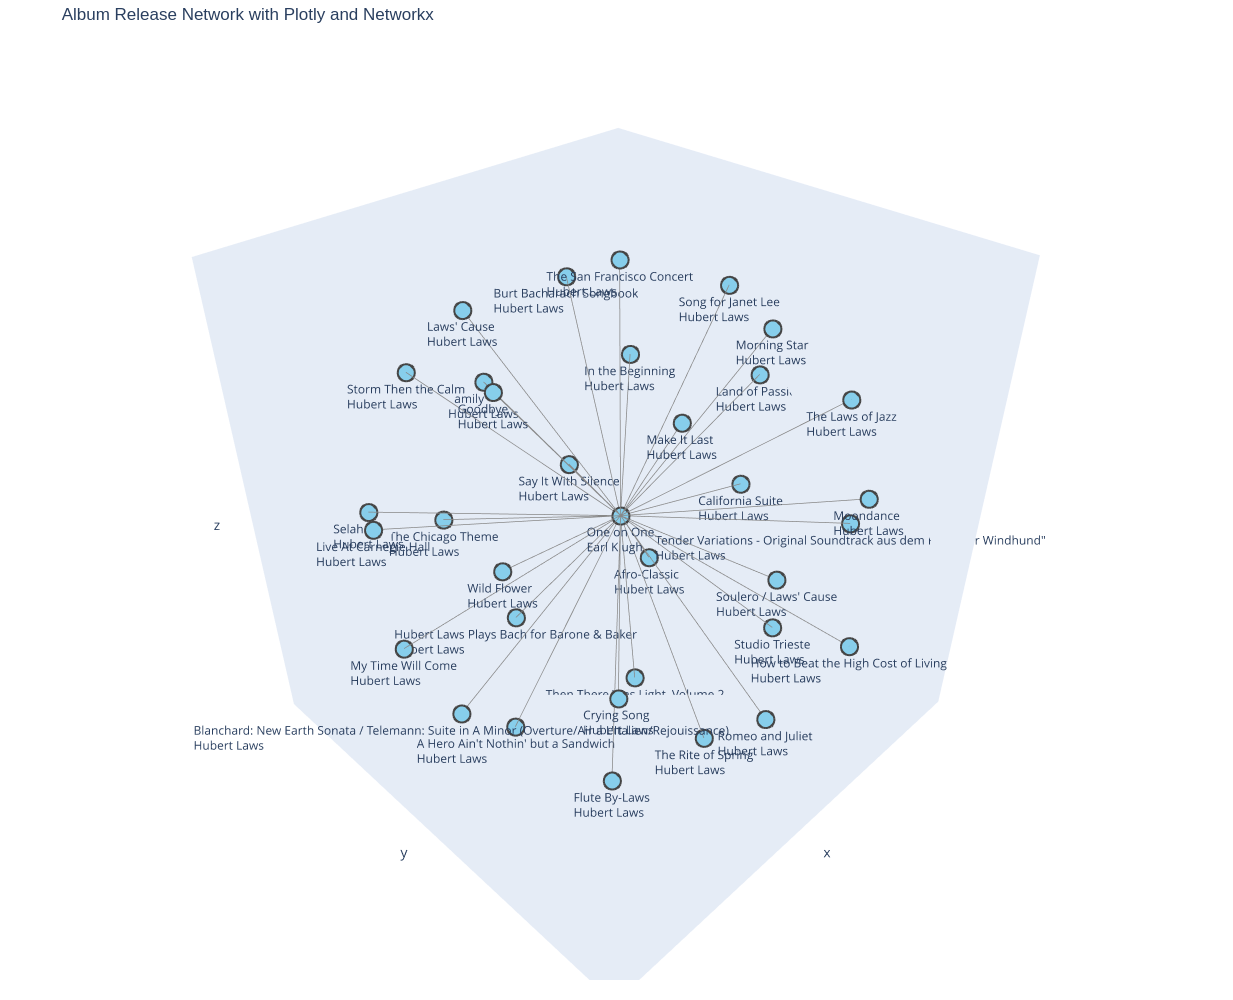

In [8]:
#Generate node positions using a NetworkX layout algorithm: NetworkX offers various layout algorithms (e.g., spring_layout, circular_layout, spectral_layout) 
#that automatically calculate node positions based on the graph structure. spring_layout is often a good default for general graphs.
pos = nx.spring_layout(G, dim=3, seed=42)


#Extract node and edge coordinates for Plotly: Iterate through the generated positions and the graph's edges to prepare the data for Plotly's go.Scatter traces.
edge_x = []
edge_y = []
edge_z = []
for edge in G.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_x.extend([x0, x1, None]) # None creates a break in the line
    edge_y.extend([y0, y1, None])
    edge_z.extend([z0, z1, None])

node_x = []
node_y = []
node_z = []
node_text = []
for node in G.nodes():
    x, y, z = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_z.append(z)
    release_info = str(node).replace('\n','<br>')
    node_text.append(release_info)

#Create Plotly traces for edges and nodes
edge_trace = go.Scatter3d(
    x = edge_x, y = edge_y, z = edge_z,
    line = dict(width = 1.5, color = '#888'),
    hoverinfo = 'none',
    mode = 'lines')

node_trace = go.Scatter3d(
    x = node_x, y = node_y, z = node_z,
    mode = 'markers+text',
    hoverinfo = 'text',
    text = node_text,
    textposition = "bottom center",
    marker = dict(
        showscale = False,
        size = 10,
        color = 'skyblue',
        line_width = 2))

#Create Plotly traces for edges and nodes:
fig = go.Figure(data = [edge_trace, node_trace],
                layout = go.Layout(
                    title = 'Album Release Network with Plotly and Networkx',
                    showlegend = False,
                    hovermode = 'closest',
                    margin = dict(b = 20,l = 5,r = 5,t = 40),
                    scene = dict(
                    xaxis = dict(showgrid = False, zeroline = False, showticklabels = False),
                    yaxis = dict(showgrid = False, zeroline = False, showticklabels = False),
                    zaxis = dict(showgrid = False, zeroline = False, showticklabels = False)
                )))
fig.update_layout(width = 1400, height = 1000)
fig.show()

In [9]:
def create_graph(name, edges):
    g = nx.Graph()
    g.add_edges_from(edges)
    g.name = name  # Optional: give it an internal name attribute
    return g

# Create graphs on the fly
graph_a = create_graph("GraphA", [(1, 2), (2, 3)])
graph_b = create_graph("GraphB", [(4, 5), (5, 6)])